# SLC inhibitor predictions

We compare a list of SLC inhibitors from the GSF lab with a background set from ChEMBL

['C#CCCC1(CCC(=O)NC2CN(/N=C/c3ccc([N+](=O)[O-])o3)C(=O)N2)N=N1; C#CCCC1(CCC(NO)=C2CN(/N=C/c3ccc([N+](=O)[O-])o3)C(=O)N2)N=N1; C#CCCC1(CCC(=O)NC2NC(=O)CN2/N=C/c2ccc([N+](=O)[O-])o2)N=N1; C#CCCC1(CCC(NO)=C2NC(=O)CN2/N=C/c2ccc([N+](=O)[O-])o2)N=N1; C#CCCC1(CCC(=O)NN([O-])c2ccc(/C=N/N3CC(=O)NC3=O)o2)N=N1; C#CCCC1(CCC(NO)=[N+]([O-])c2ccc(/C=N/N3CC(=O)NC3=O)o2)N=N1', 'C#CCCC1(CCC(NO)=c2nc(-c3ccccc3OCCC)nc3c2=NNN3)N=N1', 'C#CCCC1(CCC(=O)NC(/C(C#N)=C/c2cc(O)c(O)c([N+](=O)[O-])c2)N(CC)CC)N=N1; C#CCCC1(CCC(NO)=C(/C(C#N)=C/c2cc(O)c(O)c([N+](=O)[O-])c2)N(CC)CC)N=N1; C#CCCC1(CCC(=O)Nc2cc(/C=C(\\C#N)C(=O)N(CC)CC)cc([N+](=O)[O-])c2O)N=N1; C#CCCC1(CCC(=O)NN([O-])c2cc(/C=C(\\C#N)C(=O)N(CC)CC)cc(O)c2O)N=N1; C#CCCC1(CCC(NO)=[N+]([O-])c2cc(/C=C(\\C#N)C(=O)N(CC)CC)cc(O)c2O)N=N1; C#CCCC1(CCC(=O)Nc2c(O)cc(/C=C(\\C#N)C(=O)N(CC)CC)cc2[N+](=O)[O-])N=N1', 'C#CCCC1(CCC(=O)NC(COc2ccc(CC3SC(=O)NC3=O)cc2)c2ccc(CC)cn2)N=N1; C#CCCC1(CCC(NO)=C(COc2ccc(CC3SC(=O)NC3=O)cc2)c2ccc(CC)cn2)N=N1; C#CCCC1(CCC(=O)NC2NC(=O)C(Cc3c

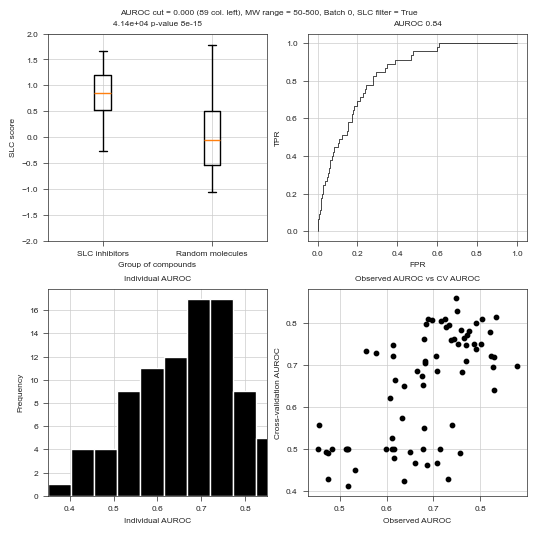

In [1]:
import pandas as pd
import joblib
import stylia
import os
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import PowerTransformer as Scaler


def get_gsf_results_data(groups=False, our_slcs_only=True, chembl_batch=0, min_auroc=0, min_mw=50, max_mw=500):

    all_slcs = list(pd.read_csv("../data/examples/slc_cemm_interest.txt", header=None)[0])
    def load_hits():
        hits, fid_prom, pid_prom = joblib.load(
            os.path.join("..", "data", "hits.joblib")
        )
        return hits, fid_prom, pid_prom

    def pid2name_mapper():
        df = pd.read_csv(
            os.path.join("..", "data/pid2name_primary.tsv"), sep="\t", header=None
        )
        df.columns = ["uniprot_ac", "gene_name"]
        name2pid = {}
        pid2name = {}
        any2pid = {}
        for r in df.values:
            name2pid[r[1]] = r[0]
            pid2name[r[0]] = r[1]
            any2pid[r[0]] = r[0]
            any2pid[r[1]] = r[0]
        return pid2name, name2pid, any2pid

    pid2name, name2pid, any2pid = pid2name_mapper()
    hits, fid_prom, pid_prom = load_hits()
    accepted_pids = set(all_slcs).intersection([x for x in pid_prom.keys()])
    di = pd.read_csv("../data/slc_inhibitor_collection_gsf_with_auto_crf.tsv")[["gene_name", "smiles_with_crf"]]
    accepted_smiles = []
    for v in di.values:
        gn = v[0]
        smiles = v[1].split("; ")
        for smi in smiles[:1]:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                continue
        if gn in name2pid:
            p = name2pid[gn]
            if p in accepted_pids:
                accepted_smiles += [v[1]]

    print(accepted_smiles)
    print(len(accepted_smiles))

    if not groups:
        df_bg = pd.read_csv("../results/2_chembl_predictions_{0}.tsv".format(chembl_batch), sep="\t")
        df_in = pd.read_csv("../results/2_gsf_predictions.tsv", sep="\t")
    else:
        df_bg = pd.read_csv("../results/2_chembl_predictions_groups_{0}.tsv".format(chembl_batch), sep="\t")
        df_in = pd.read_csv("../results/2_gsf_predictions_groups.tsv", sep="\t")

    print(df_in)

    df_in = df_in[df_in["mw"] < max_mw]
    df_bg = df_bg[df_bg["mw"] < max_mw]
    df_in = df_in[df_in["mw"] > min_mw]
    df_bg = df_bg[df_bg["mw"] > min_mw]
    if our_slcs_only:
        df_in = df_in[df_in["smiles"].isin(accepted_smiles)]

    print(df_in.shape)
    print(df_bg.shape)

    if not groups:

        protein_precalcs = joblib.load("../data/protein_precalcs.joblib")
        protein_aucs = {}
        for d in protein_precalcs:
            protein_aucs[d["uniprot_ac"]] = d["auroc"]

        slc_columns = []
        aurocs = []
        for slc in list(df_bg.columns):
            if slc not in protein_aucs:
                continue
            auroc = protein_aucs[slc][0]
            if auroc is None:
                auroc = 0
            if auroc >= min_auroc:
                slc_columns += [slc]
                aurocs += [auroc]
        
        cv_aurocs = [protein_aucs[slc][0] for slc in slc_columns]

        weights = np.clip(aurocs, 0.5, 1) - 0.5
        weights = weights / np.sum(weights)

        X_in = np.array(df_in[slc_columns])
        X_bg = np.array(df_bg[slc_columns])

    else:

        metadata = joblib.load("../results/1_experimental_validation_predictions_groups.metadata")

        slc_columns = list([x for x in df_in.columns if x.startswith("clu") or x.startswith("prot")])
        print(len(slc_columns))

        idxs = []
        aurocs = []
        for j in range(len(slc_columns)):
            auroc = metadata[j]["auroc"]
            if auroc is None:
                continue
            if auroc[0] > min_auroc:
                idxs += [j]
                aurocs += [auroc[0]]

        cv_aurocs = [x for x in aurocs]

        weights = np.clip(aurocs, 0.5, 1) - 0.5
        weights = weights / np.sum(weights)

        X_in = np.array(df_in[slc_columns])[:, idxs]
        X_bg = np.array(df_bg[slc_columns])[:, idxs]

    scaler = Scaler().fit(X_bg)
    X_bg = scaler.transform(X_bg)
    X_in = scaler.transform(X_in)

    vals_in = np.average(X_in, axis=1, weights=weights)
    vals_bg = np.average(X_bg, axis=1, weights=weights)

    return vals_in, vals_bg, X_in, X_bg, slc_columns, cv_aurocs


def gsf_plot(groups=False, our_slcs_only=True, chembl_batch=0, min_auroc=0, min_mw=50, max_mw=500):

    vals_in, vals_bg, X_in, X_bg, slc_columns, cv_aurocs = get_gsf_results_data(groups, our_slcs_only, chembl_batch, min_auroc, min_mw, max_mw)

    fig, axs = stylia.create_figure(2,2,width=stylia.TWO_COLUMNS_WIDTH*0.75, height=stylia.TWO_COLUMNS_WIDTH*0.75)
    ax = axs.next()

    ax.boxplot([vals_in, vals_bg], flierprops=dict(marker='o', markersize=3))
    ax.set_xticklabels(["SLC inhibitors", "Random molecules"])
    u_statistic, p_value = mannwhitneyu(vals_bg, vals_in)
    stylia.label(ax=ax, title="{0:.3g} p-value {1:.2g}".format(u_statistic, p_value), xlabel="Group of compounds", ylabel="SLC score")
    ax.set_ylim(-2, 2)

    ax = axs.next()
    fpr, tpr, _ = roc_curve([1]*len(vals_in) + [0]*len(vals_bg), list(vals_in) + list(vals_bg))
    ax.plot(fpr, tpr, color="black")
    stylia.label(ax=ax, title="AUROC {0:.2f}".format(auc(fpr, tpr)), xlabel="FPR", ylabel="TPR")

    ax = axs.next()
    aurocs = []
    for i in range(X_in.shape[1]):
        v1 = X_in[:, i]
        v0 = X_bg[:, i]
        fpr, tpr, _ = roc_curve([1]*len(v1) + [0]*len(v0), list(v1) + list(v0))
        aurocs += [auc(fpr, tpr)]
    ax.hist(aurocs, bins=10, color="black")
    ax.set_xlim(0.35, 0.85)
    ax.plot([0,0], [1,1], color="black", linestyle="--")
    stylia.label(ax=ax, title="Individual AUROC", xlabel="Individual AUROC", ylabel="Frequency")

    ax = axs.next()

    ax.scatter(aurocs, cv_aurocs, color="black")
    stylia.label(ax=ax, title="Observed AUROC vs CV AUROC", xlabel="Observed AUROC", ylabel="Cross-validation AUROC")

    suptitle = "AUROC cut = {0:.3f} ({1} col. left), MW range = {2}-{3}, Batch {4}, SLC filter = {5}".format(min_auroc, len(slc_columns), min_mw, max_mw, chembl_batch, our_slcs_only)
    if groups:
        suptitle = suptitle + ", Groups"
    plt.suptitle(suptitle)

    if our_slcs_only:
        inset = "our"
    else:
        inset = "all"

    filename = "../assets/gsf_validation_{0:.1f}_{1}_{2}_{3}_{4}.png".format(min_auroc, min_mw, max_mw, inset, chembl_batch)

    if groups:
        filename = filename.split(".png")[0] + "_groups.png"

    stylia.save_figure(filename)


gsf_plot()